In [11]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error
#from qiskit_experiments import *
from qiskit.quantum_info import state_fidelity

In [12]:
# Backend com ruído
backend = AerSimulator()

# Criando modelo de ruído (depolarização como exemplo)
noise_model = NoiseModel()

# Erro de 1 qubit (ex: 1% de chance de erro de porta)
error1 = depolarizing_error(0.01, 1)
# Erro de 2 qubits (ex: 2% de chance de erro de porta)
error2 = depolarizing_error(0.02, 2)

# Adiciona ruído nas portas comuns
noise_model.add_all_qubit_quantum_error(error1, ['h', 'x', 'z'])
noise_model.add_all_qubit_quantum_error(error2, ['cx', 'swap'])

In [13]:
"""from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import BackendSamplerV2
from qiskit.providers.fake_provider import GenericBackendV2

backend = AerSimulator()
sampler = Sampler(mode = backend)

from qiskit.primitives import BackendSamplerV2

#Preparação de simuladores
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend) 

#Simular o ruído 
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend = backend_sim)"""


'from qiskit_ibm_runtime import SamplerV2 as Sampler\nfrom qiskit.primitives import BackendSamplerV2\nfrom qiskit.providers.fake_provider import GenericBackendV2\n\nbackend = AerSimulator()\nsampler = Sampler(mode = backend)\n\nfrom qiskit.primitives import BackendSamplerV2\n\n#Preparação de simuladores\nfrom qiskit_aer import AerSimulator\nfrom qiskit_aer.noise import NoiseModel\nnoise_model = NoiseModel.from_backend(backend) \n\n#Simular o ruído \nbackend_sim = AerSimulator(noise_model=noise_model)\nsampler_sim = BackendSamplerV2(backend = backend_sim)'

In [14]:
def function_tel_tomography(n=0, shots=1000):
    # Registradores quânticos
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    c = ClassicalRegister(3, 'c')  # c[0] = Secret, c[1] = Alice, c[2] = tomografia

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto: H|0> = |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Entrelançamento e medições
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais baseadas nas medições
    with circuit.if_test((c[1], 1)):  # Se Alice medir 1, aplicar Z
        circuit.z(final_target)

    with circuit.if_test((c[0], 1)):  # Se Secret medir 1, aplicar X
        circuit.x(final_target)

    # =============== TOMOGRAFIA DIRETA ===============
    pauli_list = [
        np.eye(2),
        np.array([[0.0, 1.0], [1.0, 0.0]]),       # X
        np.array([[0, -1.0j], [1.0j, 0.0]]),      # Y
        np.array([[1.0, 0.0], [0.0, -1.0]])       # Z
    ]
    expectation_values = {}
    all_counts = {}

    for base in ['X', 'Y', 'Z']:
        circ = circuit.copy()

        # Aplica a rotação de base antes da medição
        if base == 'X':
            circ.h(final_target)
        elif base == 'Y':
            circ.sdg(final_target)
            circ.h(final_target)

        # Mede o qubit final no registrador c[2]
        circ.measure(final_target, c[2])

        #Execução
        transpiled = transpile(
        circ,
        backend,
        basis_gates=['swap','h','x','z','cx','measure','sdg'],
        optimization_level=0
        )
        result = backend.run(transpiled, shots=100000, noise_model=noise_model).result()
        counts= result.get_counts()

        # Obtenção dos valores esperados
        p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
        p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
        total = p0 + p1 or 1
        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    # Reconstrução da matriz densidade
    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    return rho, expectation_values, circuit

### Analise de onde esta sendo feita a medicao

In [15]:
"""rho_4 ,expectation_values_1, circuit_1, counts_1 ,circ= function_tel_tomography(n=4, shots=10000)
print("rho_1 =\n", rho_4)

circ.draw("mpl")"""

'rho_4 ,expectation_values_1, circuit_1, counts_1 ,circ= function_tel_tomography(n=4, shots=10000)\nprint("rho_1 =\n", rho_4)\n\ncirc.draw("mpl")'

#### Rhos

In [16]:
rho_0 ,expectation_values_0, circuit_0 = function_tel_tomography(n=0, shots=10000)
print("rho_0 =\n", rho_0)

rho_1 ,expectation_values_1, circuit_1 = function_tel_tomography(n=1, shots=10000)
print("rho_1 =\n", rho_1)

rho_2 ,expectation_values_2, circuit_2 = function_tel_tomography(n=2, shots=10000)
print("rho_2 =\n", rho_2)

rho_3 ,expectation_values_3, circuit_3 = function_tel_tomography(n=3, shots=10000)
print("rho_3 =\n", rho_3)

rho_4 ,expectation_values_4, circuit_4 = function_tel_tomography(n=4, shots=10000)
print("rho_4 =\n", rho_4)

rho_5 ,expectation_values_5, circuit_5 = function_tel_tomography(n=5, shots=10000)
print("rho_5 =\n", rho_5)

rho_6 ,expectation_values_6, circuit_6 = function_tel_tomography(n=6, shots=10000)
print("rho_6 =\n", rho_6)

rho_7 ,expectation_values_7, circuit_7= function_tel_tomography(n=7, shots=10000)
print("rho_7 =\n", rho_7)

rho_8 ,expectation_values_8, circuit_8 = function_tel_tomography(n=8, shots=10000)
print("rho_8 =\n", rho_8)

rho_9 ,expectation_values_9, circuit_9 = function_tel_tomography(n=9, shots=10000)
print("rho_9 =\n", rho_9)

rho_10 ,expectation_values_10, circuit_10 = function_tel_tomography(n=10, shots=10000)
print("rho_10 =\n", rho_10)


rho_0 =
 [[0.49872+0.j      0.45704-0.00176j]
 [0.45704+0.00176j 0.50128+0.j     ]]
rho_1 =
 [[0.50227+0.j      0.44711+0.00173j]
 [0.44711-0.00173j 0.49773+0.j     ]]
rho_2 =
 [[0.50239+0.j      0.44016-0.00087j]
 [0.44016+0.00087j 0.49761+0.j     ]]
rho_3 =
 [[0.49983+0.j      0.4294 +0.00184j]
 [0.4294 -0.00184j 0.50017+0.j     ]]
rho_4 =
 [[0.50137+0.j     0.4214 +0.0022j]
 [0.4214 -0.0022j 0.49863+0.j    ]]
rho_5 =
 [[0.50067+0.j     0.4127 -0.0003j]
 [0.4127 +0.0003j 0.49933+0.j    ]]
rho_6 =
 [[0.49808+0.j      0.40536+0.00077j]
 [0.40536-0.00077j 0.50192+0.j     ]]
rho_7 =
 [[0.49965+0.j      0.39608+0.00028j]
 [0.39608-0.00028j 0.50035+0.j     ]]
rho_8 =
 [[0.5009 +0.j      0.38801-0.00458j]
 [0.38801+0.00458j 0.4991 +0.j     ]]
rho_9 =
 [[0.49863+0.j     0.38205-0.0008j]
 [0.38205+0.0008j 0.50137+0.j    ]]
rho_10 =
 [[0.50364+0.j      0.37436+0.00134j]
 [0.37436-0.00134j 0.49636+0.j     ]]


#### Circuitos

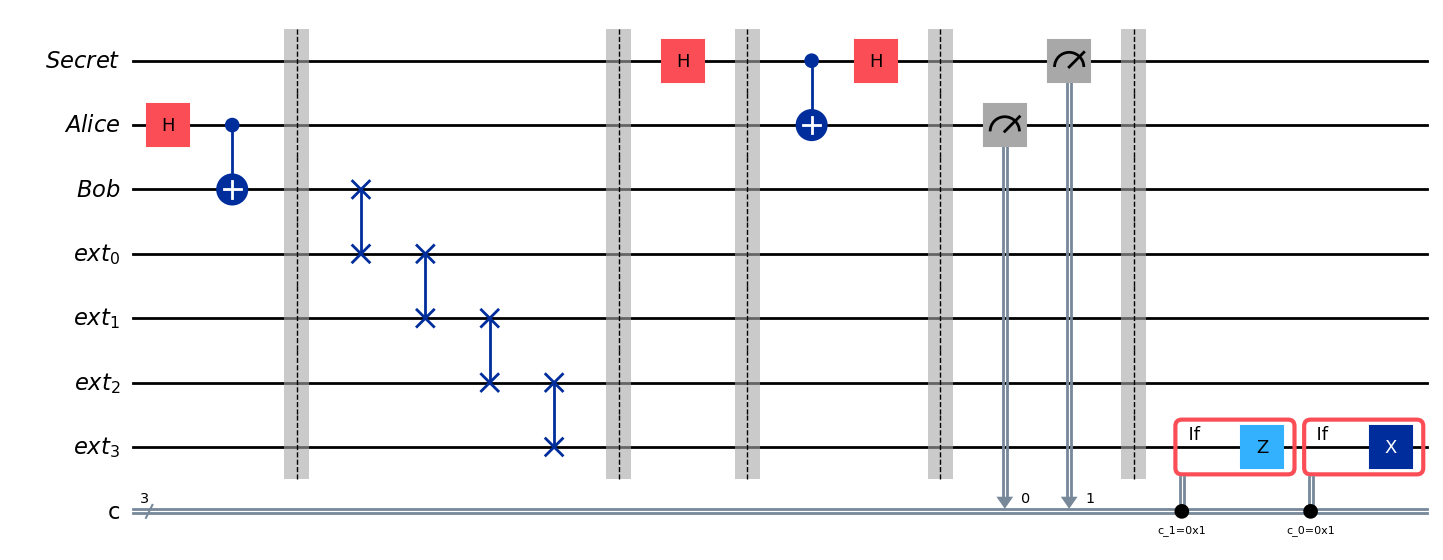

In [17]:
circuit_4.draw('mpl')

#### Obtencao das fidelidades


In [22]:
from qiskit.quantum_info import state_fidelity

rho_ref = rho_0  
fidelidade_0 = state_fidelity(rho_ref, rho_0)
print("Fidelidade entre rho_0 e rho_0:", fidelidade_0)

fidelidade_1 = state_fidelity(rho_ref, rho_1)
print("Fidelidade entre rho_0 e rho_1:", fidelidade_1)

fidelidade_2 = state_fidelity(rho_ref, rho_2)
print("Fidelidade entre rho_0 e rho_2:", fidelidade_2)

fidelidade_3 = state_fidelity(rho_ref, rho_3)
print("Fidelidade entre rho_0 e rho_3:", fidelidade_3)

fidelidade_4 = state_fidelity(rho_ref, rho_4)
print("Fidelidade entre rho_0 e rho_4:", fidelidade_4)

fidelidade_5 = state_fidelity(rho_ref, rho_5)
print("Fidelidade entre rho_0 e rho_5:", fidelidade_5)

fidelidade_6 = state_fidelity(rho_ref, rho_6)
print("Fidelidade entre rho_0 e rho_6:", fidelidade_6)

fidelidade_7 = state_fidelity(rho_ref, rho_7)
print("Fidelidade entre rho_0 e rho_7:", fidelidade_7)

fidelidade_8 = state_fidelity(rho_ref, rho_8)
print("Fidelidade entre rho_0 e rho_8:", fidelidade_8)

fidelidade_9 = state_fidelity(rho_ref, rho_9)
print("Fidelidade entre rho_0 e rho_9:", fidelidade_9)

fidelidade_10 = state_fidelity(rho_ref, rho_10)
print("Fidelidade entre rho_0 e rho_10:", fidelidade_10)


Fidelidade entre rho_0 e rho_0: 0.9999999999999996
Fidelidade entre rho_0 e rho_1: 0.9994339143496616
Fidelidade entre rho_0 e rho_2: 0.9985159820928089
Fidelidade entre rho_0 e rho_3: 0.9963709663127358
Fidelidade entre rho_0 e rho_4: 0.9943053375440721
Fidelidade entre rho_0 e rho_5: 0.9917049269556648
Fidelidade entre rho_0 e rho_6: 0.9892305619510138
Fidelidade entre rho_0 e rho_7: 0.9857928605104193
Fidelidade entre rho_0 e rho_8: 0.9825514263165793
Fidelidade entre rho_0 e rho_9: 0.9800259911646121
Fidelidade entre rho_0 e rho_10: 0.976575462638478


#### Grafico SWAP x Fidelidade

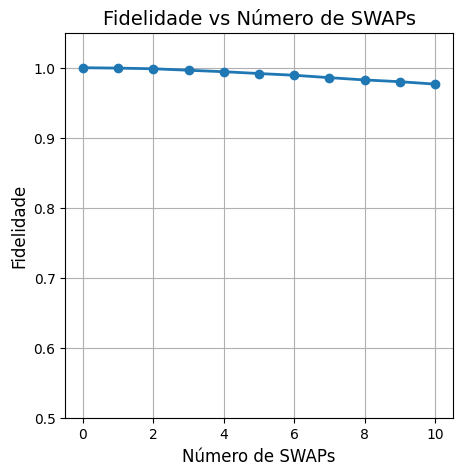

In [26]:
import matplotlib.pyplot as plt

# Colocando os valores já obtidos em uma lista
fidelidades = [
    fidelidade_0,
    fidelidade_1,
    fidelidade_2,
    fidelidade_3,
    fidelidade_4,
    fidelidade_5,
    fidelidade_6,
    fidelidade_7,
    fidelidade_8,
    fidelidade_9,
    fidelidade_10
]

# Criando eixo de swaps (0 a 10)
swaps = list(range(len(fidelidades)))

# Plotando
plt.figure(figsize=(5,5))
plt.plot(swaps, fidelidades, marker='o', linestyle='-', linewidth=2)

plt.title("Fidelidade vs Número de SWAPs", fontsize=14)
plt.xlabel("Número de SWAPs", fontsize=12)
plt.ylabel("Fidelidade", fontsize=12)

# Limitando o eixo y de 0.5 a 1
plt.ylim(0.5, 1.05)

plt.grid(True)
plt.show()




#### Plots

In [27]:
def von_neumann_entropy(rho):
    # Calcula autovalores da matriz densidade
    eigenvals = np.linalg.eigvals(rho)
    # Remove autovalores numéricamente muito pequenos (≈0)
    eigenvals = [ev for ev in np.real(eigenvals) if ev > 1e-12]
    # Fórmula da entropia
    return -np.sum([ev * np.log2(ev) for ev in eigenvals])

# Calcular entropias para cada rho reconstruído
Entropia_0=von_neumann_entropy(rho_0)
print("Entropia_0: ",Entropia_0)
Entropia_1=von_neumann_entropy(rho_1)
print("Entropia_1: ",Entropia_1)
Entropia_2=von_neumann_entropy(rho_2)
print("Entropia_2): ",Entropia_2)
Entropia_3=von_neumann_entropy(rho_3)
print("Entropia_3: ",Entropia_3)
Entropia_4=von_neumann_entropy(rho_4)
print("Entropia_4: ",Entropia_4)
Entropia_5=von_neumann_entropy(rho_5)
print("Entropia_5: ",Entropia_5)
Entropia_6=von_neumann_entropy(rho_6)
print("Entropia_6: ",Entropia_6)
Entropia_7=von_neumann_entropy(rho_7)
print("Entropia_7: ",Entropia_7)
Entropia_8=von_neumann_entropy(rho_8)
print("Entropia_8: ",Entropia_8)
Entropia_9=von_neumann_entropy(rho_9)
print("Entropia_9: ",Entropia_9)
Entropia_10=von_neumann_entropy(rho_10)
print("Entropia_10: ",Entropia_10)


Entropia_0:  0.2556796440989705
Entropia_1:  0.2985109623557439
Entropia_2):  0.32678025002654204
Entropia_3:  0.36814396999560234
Entropia_4:  0.39719858771126393
Entropia_5:  0.42739056290972965
Entropia_6:  0.4517535719996365
Entropia_7:  0.48129915278073465
Entropia_8:  0.5058055056375833
Entropia_9:  0.5234297928303022
Entropia_10:  0.5453022084625418


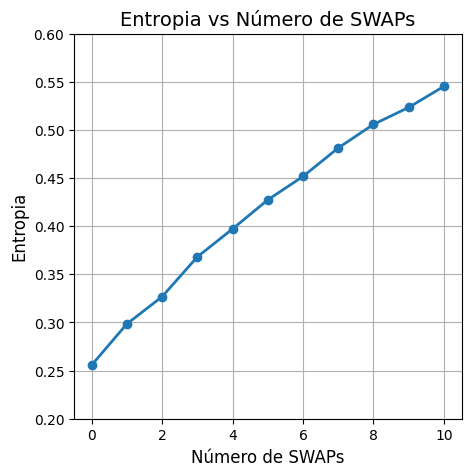

In [28]:
import matplotlib.pyplot as plt

# Colocando os valores já obtidos em uma lista
entropias = [
  Entropia_0,
  Entropia_1,
  Entropia_2,
  Entropia_3,
  Entropia_4,
  Entropia_5,
  Entropia_6,
  Entropia_7,
  Entropia_8,
  Entropia_9,
  Entropia_10
]

# Criando eixo de swaps (0 a 10)
swaps = list(range(len(entropias)))

# Plotando
plt.figure(figsize=(5,5))
plt.plot(swaps, entropias, marker='o', linestyle='-', linewidth=2)

plt.title("Entropia vs Número de SWAPs", fontsize=14)
plt.xlabel("Número de SWAPs", fontsize=12)
plt.ylabel("Entropia", fontsize=12)

# Limitando o eixo y de 0.5 a 1
plt.ylim(0.20, 0.60)

plt.grid(True)
plt.show()